In [75]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os, sys
sys.path.append(os.path.join("../.."))

import numpy as np

import torch as t
t.set_default_dtype(t.float32)

import pymc3 as pm
import pandas as pd

import pyro
import pyro.distributions as dist
import pyro.contrib.autoname as au
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, JitTrace_ELBO
from pyro.optim import Adam
from torch.distributions import constraints
from torch.distributions.utils import broadcast_all

import arviz as az
import matplotlib.pyplot as plt
import privugger as pv



In [2]:
def dp_program(age,sex,educ,race,income,married,N):
    import opendp.smartnoise.core as sn
    import pandas as pd


    
    ## Dataframe definition (can be automatized)
    temp_file='temp.csv'
    var_names = ["age", "sex", "educ", "race", "income", "married"]
    data = {
        "age":     age,
        "sex":     sex,
        "educ":    educ,
        "race":    race,
        "income":  income,
        "married": married
    }
    df = pd.DataFrame(data,columns=var_names)
    
    ## After here the program works on a pandas dataframe
    df.to_csv(temp_file)
    with sn.Analysis() as analysis:
        # load data
        data = sn.Dataset(path=temp_file,column_names=var_names)

        # get mean of age
        age_mean = sn.dp_mean(data = sn.to_float(data['income']),
                              privacy_usage = {'epsilon': .1},
                              data_lower = 0., # min income
                              data_upper = 200., # max income                   
                              data_rows = N
                             )
    analysis.release()
    return np.float64(age_mean.value)   

In [113]:
def model(program):
    age = pyro.sample
    sex = pyro.sample('sex', uniform_converter(sex))
    educ = pyro.sample('educ', uniform_converter(educ))
    race = pyro.sample('race', uniform_converter(race))
    married = pyro.sample('married', uniform_converter(married))
    income = pyro.sample('income',  dist.Normal(100, 5))
    
    program = pyro.determinsitic('program', program() )

    return program

  

def guide(data):
    sex_loc =  pyro.param('sex_loc', t.tensor(1.),
                            constraint=constraints.positive)
    educ_loc = pyro.param('educ_loc', t.tensor(5.),
                            constraint=constraints.positive)
    race_loc = pyro.param('race_loc', t.tensor(25.),
                            constraint=constraints.positive)
    married_loc = pyro.param('married_loc', t.tensor(1.),
                            constraint=constraints.positive)
    income_loc = pyro.param('income_loc', t.tensor(1.),
                            constraint=constraints.positive)
    income_scale = pyro.param('income_scale', t.tensor(1.),
                            constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', t.tensor(0.),
                            constraint=constraints.positive)
    
    income = pyro.sample('income', dist.Normal(income_loc, income_scale))
    sex_guide = pyro.sample("sex", dist.Normal(sex_loc, t.tensor(0.05)))
    educ_guide = pyro.sample("educ", dist.Normal(educ_loc, t.tensor(0.05)))
    race_guide = pyro.sample("race", dist.Normal(race_loc, t.tensor(0.05)))
    married_guide = pyro.sample("married", dist.Normal(married_loc, t.tensor(0.05)))
    
    sigma = pyro.sample("sigma", dist.Uniform(sigma_loc, t.tensor(5.)))

    program = dp_program(data, sex_guide.detach().numpy(), educ_guide.detach().numpy(), race_guide.detach().numpy(), income.detach().numpy(), married_guide.detach().numpy(), N)

In [ ]:
nuts_kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True)

mcmc = MCMC(nuts_kernel, num_samples=20000, warmup_steps=1000, num_chains=2)
mcmc.run(age)

prior = Predictive(model, num_samples=500)(age)
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples=posterior_samples)(age)

In [ ]:
pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
)
pyro_data

array([[<AxesSubplot:title={'center':'educ'}>,
        <AxesSubplot:title={'center':'educ'}>],
       [<AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'income'}>],
       [<AxesSubplot:title={'center':'married'}>,
        <AxesSubplot:title={'center':'married'}>],
       [<AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'race'}>],
       [<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'sex'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

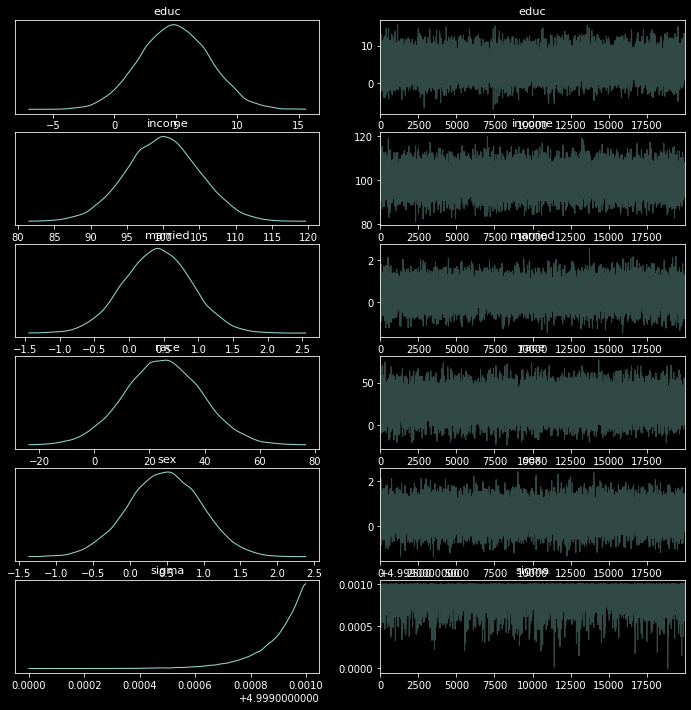

In [112]:
az.plot_trace(pyro_data, compact=True)